<a href="https://colab.research.google.com/github/uldkh/colab_projects/blob/main/1_LSTM_CNN_predict_bitcoin_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import keras.backend as K
import keras_tuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, GlobalMaxPooling1D, LSTM, RepeatVector, TimeDistributed, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from statsmodels.tsa.stattools import acf, ccf

import os
import gc
import requests
import pickle
import time
from tqdm import tqdm

In [ ]:
def set_plt_params(fontsize=11, linewidth=2.3, figsize=(17.87, 10.45)):

  plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9'])
  plt.rcParams['lines.linewidth'] = linewidth
  plt.rc("axes", facecolor="#181c27", edgecolor="#2a2e39", grid=True)
  plt.rc("figure", figsize=figsize, facecolor="#181c27", edgecolor="#2a2e39")
  plt.rc("grid", color="#2a2e39", linestyle="dashed")
  plt.rc("xtick", labelsize=fontsize, color="#b2b5be", bottom=False)
  plt.rc("ytick", labelsize=fontsize, color="#b2b5be", left=False)
  plt.rc("legend", handleheight=1, handlelength=2)
  plt.rc("text", color="#b2b5be")

set_plt_params()

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/My Drive/DataBases/btc_data"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/DataBases/btc_data.rar

Creating    btc_data                                                  OK
Extracting  btc_data/Bitstamp_BTCUSD_2017_minute.csv                       0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18%  OK 
Extracting  btc_data/Bitstamp_BTCUSD_2018_minute.csv                      18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38%  OK 
Extracting  btc_data/Bitstamp_BTCUSD_2019_minute.csv                      38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58%  OK 
Extracting  btc_data/Bitstamp_BTCUSD_2020_minute.csv  

#Сбор и конкат данных по цене

In [ ]:
dir = "/content/btc_data/"

for i in tqdm(os.listdir(dir)):
  if "2017" in dir + i:
    btc_data_2017 = pd.read_csv(dir + i)
  elif "2018" in dir + i:
    btc_data_2018 = pd.read_csv(dir + i)
  elif "2019" in dir + i:
    btc_data_2019 = pd.read_csv(dir + i)
  elif "2020" in dir + i:
    btc_data_2020 = pd.read_csv(dir + i)
  elif "2021" in dir + i:
    btc_data_2021 = pd.read_csv(dir + i)

100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


In [ ]:
btc_data_2017.shape, btc_data_2018.shape, btc_data_2019.shape, btc_data_2020.shape, btc_data_2021.shape

((525599, 9), (525599, 9), (525599, 9), (487722, 9), (497487, 9))

In [ ]:
btc_data_2017.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1514764740,2017-12-31 23:59:00,BTC/USD,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549
1,1514764680,2017-12-31 23:58:00,BTC/USD,13913.26,13953.83,13884.69,13953.77,1.398784,19518.309658
2,1514764620,2017-12-31 23:57:00,BTC/USD,13908.73,13913.26,13874.99,13913.26,0.775012,10782.944294
3,1514764560,2017-12-31 23:56:00,BTC/USD,13827.00,13908.69,13827.00,13859.58,0.666459,9236.841134
4,1514764500,2017-12-31 23:55:00,BTC/USD,13825.05,13825.05,13825.05,13825.05,0.065501,905.560130


In [ ]:
btc_data = pd.concat([btc_data_2019, btc_data_2018, btc_data_2017], ignore_index=True)

In [ ]:
btc_data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1577836740,2019-12-31 23:59:00,BTC/USD,7167.30,7171.22,7167.30,7168.36,0.191448,1372.366393
1,1577836680,2019-12-31 23:58:00,BTC/USD,7166.89,7167.30,7161.99,7167.30,0.568868,4077.245538
2,1577836620,2019-12-31 23:57:00,BTC/USD,7164.22,7170.80,7161.65,7166.89,3.959440,28376.874525
3,1577836560,2019-12-31 23:56:00,BTC/USD,7182.49,7182.49,7170.20,7170.20,6.248892,44805.802550
4,1577836500,2019-12-31 23:55:00,BTC/USD,7175.69,7176.68,7175.69,7176.68,0.016877,121.122623


In [ ]:
(abs(btc_data.close - btc_data["Volume USD"] / btc_data["Volume BTC"])).max()

7.275957614183426e-12

In [ ]:
pd.to_datetime(btc_data_2020.iloc[0, 0], unit="s") - pd.to_datetime(btc_data_2020.iloc[-1, 0], unit="s")

Timedelta('365 days 23:58:00')

In [ ]:
def check_date(series_unix_data):
  missed_date_indexes = []
  cur_time = series_unix_data[0]

  for i, v in enumerate(series_unix_data):

    if v != cur_time:
      missed_date_indexes.append(i)
    cur_time = v - 60

  return missed_date_indexes

In [ ]:
missed_date_indexes = check_date(btc_data.unix)
len(missed_date_indexes)

2

In [ ]:
missed_date_indexes

[525599, 1051198]

In [ ]:
for i in missed_date_indexes:
  print(btc_data.date[i-1 : i+1])

525598    2019-01-01 00:01:00
525599    2018-12-31 23:59:00
Name: date, dtype: object
1051197    2018-01-01 00:01:00
1051198    2017-12-31 23:59:00
Name: date, dtype: object


In [ ]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576797 entries, 0 to 1576796
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   unix        1576797 non-null  int64  
 1   date        1576797 non-null  object 
 2   symbol      1576797 non-null  object 
 3   open        1576797 non-null  float64
 4   high        1576797 non-null  float64
 5   low         1576797 non-null  float64
 6   close       1576797 non-null  float64
 7   Volume BTC  1576797 non-null  float64
 8   Volume USD  1576797 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 108.3+ MB


In [ ]:
def insert_row(df, row_number, row_value):

    df1 = df[:row_number]
    df2 = df[row_number:]
    df1.loc[row_number] = row_value
    df_result = pd.concat([df1, df2])
    df_result.index = [*range(df_result.shape[0])]
  
    return df_result

In [ ]:
row_value_1 = [1546300800, "2019-01-01 00:00:00", "BTC/USD", 3693.30, 3696.30, 3692.62, 3694.72, 9.738855, 35982.841473]
btc_data = insert_row(btc_data, missed_date_indexes[0], row_value_1)

In [ ]:
btc_data[missed_date_indexes[0]-1: missed_date_indexes[0] +2]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
525598,1546300860,2019-01-01 00:01:00,BTC/USD,3694.72,3694.72,3690.65,3690.65,9.500151,35061.732362
525599,1546300800,2019-01-01 00:00:00,BTC/USD,3693.30,3696.30,3692.62,3694.72,9.738855,35982.841473
525600,1546300740,2018-12-31 23:59:00,BTC/USD,3689.26,3693.30,3689.26,3693.30,9.838855,36337.841473


In [ ]:
missed_date_indexes = check_date(btc_data.unix)
missed_date_indexes

[1051199]

In [ ]:
row_value_2 = [1514764800, "2018-01-01 00:00:00", "BTC/USD", 13880.00, 13890.41, 13839.04, 13841.01, 0.738855, 10226.841473]
btc_data = insert_row(btc_data, missed_date_indexes[0], row_value_2)

In [ ]:
btc_data[missed_date_indexes[0]-1: missed_date_indexes[0] +2]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
1051198,1514764860,2018-01-01 00:01:00,BTC/USD,13841.01,13890.43,13841.01,13890.43,1.665850,23139.366704
1051199,1514764800,2018-01-01 00:00:00,BTC/USD,13880.00,13890.41,13839.04,13841.01,0.738855,10226.841473
1051200,1514764740,2017-12-31 23:59:00,BTC/USD,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549


In [ ]:
missed_date_indexes = check_date(btc_data.unix)
len(missed_date_indexes)

0

In [ ]:
missed_date_indexes = check_date(btc_data_2021.unix)
len(missed_date_indexes)

0

In [ ]:
missed_date_indexes = check_date(btc_data_2020.unix)
len(missed_date_indexes)

2

In [ ]:
missed_date_indexes

[16807, 16808]

In [ ]:
btc_data_2020.iloc[16806:16809]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
16806,1608450780,2020-12-20 07:53:00,BTC/USD,23573.41,23592.83,23568.19,23592.83,6.861060,161871.822436
16807,1606091760,2020-11-23 00:36:00,BTC/USD,18247.67,18247.67,18208.72,18214.47,6.347324,115613.140757
16808,1606091640,2020-11-23 00:34:00,BTC/USD,18216.04,18315.42,18216.04,18291.86,5.136150,93949.734910


In [ ]:
btc_data_2019_2021 = pd.read_csv("/content/drive/MyDrive/DataBases/Binance_BTCUSDT_minute.csv")

In [ ]:
btc_data_2019_2021

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1639281900000,2021-12-12 04:05:00,BTC/USDT,49176.92,49202.25,49130.00,49160.00,50.81359,2.498029e+06,1200
1,1639281840000,2021-12-12 04:04:00,BTC/USDT,49243.24,49246.64,49150.00,49176.93,49.22467,2.421988e+06,1356
2,1639281780000,2021-12-12 04:03:00,BTC/USDT,49275.85,49284.20,49241.06,49243.25,13.65856,6.728304e+05,589
3,1639281720000,2021-12-12 04:02:00,BTC/USDT,49321.79,49321.79,49267.40,49275.86,13.57473,6.691039e+05,631
4,1639281660000,2021-12-12 04:01:00,BTC/USDT,49327.18,49347.53,49321.78,49321.79,5.62087,2.773197e+05,375
...,...,...,...,...,...,...,...,...,...,...
1048569,1576043280000,2019-12-11 05:48:00,BTC/USDT,7204.79,7205.29,7204.79,7204.80,4.97200,3.582276e+04,25
1048570,1576043220000,2019-12-11 05:47:00,BTC/USDT,7207.85,7208.45,7204.80,7204.87,51.71100,3.726488e+05,61
1048571,1576043160000,2019-12-11 05:46:00,BTC/USDT,7207.00,7208.46,7206.56,7208.46,30.66500,2.210292e+05,49
1048572,1576043100000,2019-12-11 05:45:00,BTC/USDT,7204.50,7208.00,7204.50,7206.84,70.77700,5.100601e+05,134


In [ ]:
(abs(btc_data_2019_2021.close - btc_data_2019_2021["Volume USDT"] / btc_data_2019_2021["Volume BTC"])).max()

1022.6069590680854

In [ ]:
(abs(btc_data_2019_2021.close - btc_data_2019_2021["Volume USDT"] / btc_data_2019_2021["Volume BTC"]) > btc_data_2019_2021.close * 0.01).sum()

191

In [ ]:
btc_data_2021.drop(["Volume USD", "symbol"], axis=1, inplace=True)
btc_data_2020.drop(["Volume USD", "symbol"], axis=1, inplace=True)
btc_data.drop(["Volume USD", "symbol"], axis=1, inplace=True)
btc_data_2019_2021.drop(["Volume USDT", "symbol"], axis=1, inplace=True)

In [ ]:
btc_data_2019_2021[["unix"]] = btc_data_2019_2021[["unix"]].apply(lambda x: x//1000)

In [ ]:
missed_date_indexes = check_date(btc_data_2019_2021.unix)
len(missed_date_indexes)

10

In [ ]:
missed_date_indexes

[106266,
 173976,
 282315,
 327906,
 335077,
 399787,
 432727,
 501888,
 506688,
 537358]

In [ ]:
btc_data_2019_2021[missed_date_indexes[0] - 1 : missed_date_indexes[0] + 2]

,unix,date,open,high,low,close,Volume BTC,tradecount
106265,1632906000,2021-09-29 09:00:00,42442.00,42442.02,42000.0,42250.01,35.69196,1900
106266,1632898740,2021-09-29 06:59:00,42420.41,42456.39,42420.0,42450.25,8.91879,336
106267,1632898680,2021-09-29 06:58:00,42385.76,42420.41,42381.8,42420.00,5.36774,236


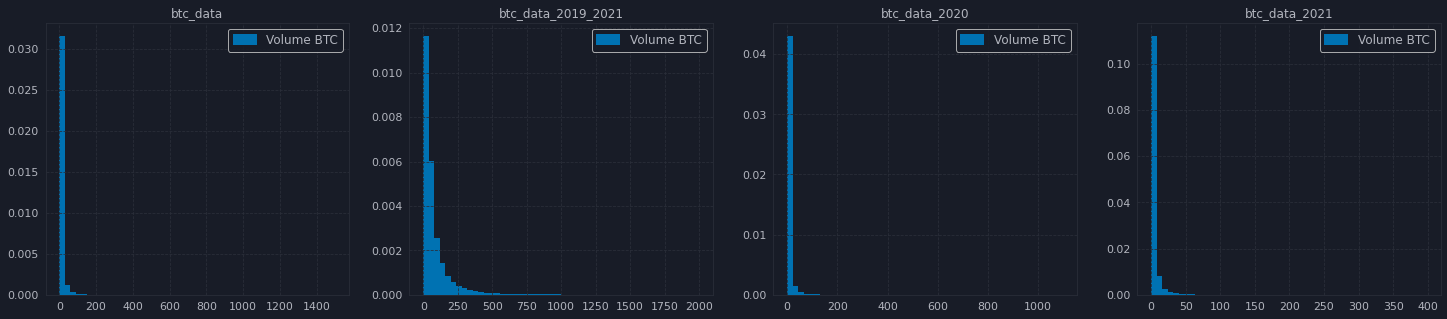

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(25, 5))

axs[0].hist(btc_data["Volume BTC"][btc_data["Volume BTC"] < 1500], bins=50, density=True, label="Volume BTC")
axs[1].hist(btc_data_2019_2021["Volume BTC"][btc_data_2019_2021["Volume BTC"] < 2000], bins=50, density=True, label="Volume BTC")
axs[2].hist(btc_data_2020["Volume BTC"][btc_data_2020["Volume BTC"] < 2500], bins=50, density=True, label="Volume BTC")
axs[3].hist(btc_data_2021["Volume BTC"][btc_data_2021["Volume BTC"] < 2000], bins=50, density=True, label="Volume BTC")

axs[0].set_title("btc_data")
axs[1].set_title("btc_data_2019_2021")
axs[2].set_title("btc_data_2020")
axs[3].set_title("btc_data_2021")


axs[0].legend(fontsize = 12)
axs[1].legend(fontsize = 12)
axs[2].legend(fontsize = 12)
axs[3].legend(fontsize = 12)

plt.show()

In [ ]:
print("Volume BTC - mean, std:", btc_data["Volume BTC"].mean(), btc_data["Volume BTC"].std())
print("Volume BTC - mean, std:", btc_data_2020["Volume BTC"].mean(), btc_data_2020["Volume BTC"].std())
print("Volume BTC - mean, std:", btc_data_2021["Volume BTC"].mean(), btc_data_2021["Volume BTC"].std())

Volume BTC - mean, std: 7.3692024850069915 18.260403656109876
Volume BTC - mean, std: 5.839294922335728 16.853527268033012
Volume BTC - mean, std: 3.55669377617116 8.452848547438057


In [ ]:
print("Volume BTC - mean, std:", btc_data_2019_2021["Volume BTC"].mean(), btc_data_2019_2021["Volume BTC"].std())

Volume BTC - mean, std: 96.66165554860252 225.36511754287588


In [ ]:
btc_data[["date"]] = pd.to_datetime(btc_data.date)
btc_data_2020[["date"]] = pd.to_datetime(btc_data_2020.date)
btc_data_2021[["date"]] = pd.to_datetime(btc_data_2021.date)
btc_data_2019_2021[["date"]] = pd.to_datetime(btc_data_2019_2021.date)

In [ ]:
btc_data[["Volume BTC"]] = btc_data[["Volume BTC"]].apply(lambda x: x * 13)
btc_data_2020[["Volume BTC"]] = btc_data_2020[["Volume BTC"]].apply(lambda x: x * 17)
btc_data_2021[["Volume BTC"]] = btc_data_2021[["Volume BTC"]].apply(lambda x: x * 27)

In [ ]:
btc_data = pd.concat([btc_data_2021, btc_data_2020, btc_data], ignore_index=True)

In [ ]:
for i in missed_date_indexes:
  print(btc_data_2019_2021.date[i-1 : i+1])

106265   2021-09-29 09:00:00
106266   2021-09-29 06:59:00
Name: date, dtype: datetime64[ns]
173975   2021-08-13 06:30:00
173976   2021-08-13 01:59:00
Name: date, dtype: datetime64[ns]
282314   2021-05-29 20:21:00
282315   2021-05-27 00:35:00
Name: date, dtype: datetime64[ns]
327905   2021-04-25 08:45:00
327906   2021-04-25 04:00:00
Name: date, dtype: datetime64[ns]
335076   2021-04-20 04:30:00
335077   2021-04-20 01:59:00
Name: date, dtype: datetime64[ns]
399786   2021-03-06 03:30:00
399787   2021-03-06 01:59:00
Name: date, dtype: datetime64[ns]
432726   2021-02-11 05:00:00
432727   2021-02-11 03:40:00
Name: date, dtype: datetime64[ns]
501887   2020-12-25 03:00:00
501888   2020-12-25 01:59:00
Name: date, dtype: datetime64[ns]
506687   2020-12-21 18:00:00
506688   2020-12-21 14:09:00
Name: date, dtype: datetime64[ns]
537357   2020-11-30 07:00:00
537358   2020-11-30 05:59:00
Name: date, dtype: datetime64[ns]


In [ ]:
missed_date_indexes = check_date(btc_data.unix)
len(missed_date_indexes)

4

In [ ]:
for i in missed_date_indexes:
  print(btc_data.date[i-1 : i+1])

497486   2021-01-01 00:01:00
497487   2020-12-31 23:59:00
Name: date, dtype: datetime64[ns]
514293   2020-12-20 07:53:00
514294   2020-11-23 00:36:00
Name: date, dtype: datetime64[ns]
514294   2020-11-23 00:36:00
514295   2020-11-23 00:34:00
Name: date, dtype: datetime64[ns]
985208   2020-01-01 00:01:00
985209   2019-12-31 23:59:00
Name: date, dtype: datetime64[ns]


In [ ]:
btc_data = btc_data_2019_2021.merge(btc_data, how="outer", on=["unix", "date"])
btc_data = btc_data[btc_data["date"] <= "2021-12-12 04:05:00"]
btc_data.head()

,unix,date,open_x,high_x,low_x,close_x,Volume BTC_x,tradecount,open_y,high_y,low_y,close_y,Volume BTC_y
0,1639281900,2021-12-12 04:05:00,49176.92,49202.25,49130.00,49160.00,50.81359,1200.0,49207.29,49207.29,49171.57,49199.09,41.213501
1,1639281840,2021-12-12 04:04:00,49243.24,49246.64,49150.00,49176.93,49.22467,1356.0,49264.39,49264.39,49221.35,49222.23,1.810929
2,1639281780,2021-12-12 04:03:00,49275.85,49284.20,49241.06,49243.25,13.65856,589.0,49310.33,49314.15,49271.97,49282.15,7.685820
3,1639281720,2021-12-12 04:02:00,49321.79,49321.79,49267.40,49275.86,13.57473,631.0,49341.59,49341.59,49319.29,49319.29,0.350190
4,1639281660,2021-12-12 04:01:00,49327.18,49347.53,49321.78,49321.79,5.62087,375.0,49366.00,49377.00,49358.72,49358.72,0.167059


In [ ]:
btc_data.set_index("unix", drop=True, inplace=True)
btc_data.sort_index(ascending=False,inplace=True)
btc_data.reset_index(inplace=True)
btc_data.head()

,unix,date,open_x,high_x,low_x,close_x,Volume BTC_x,tradecount,open_y,high_y,low_y,close_y,Volume BTC_y
0,1639281900,2021-12-12 04:05:00,49176.92,49202.25,49130.00,49160.00,50.81359,1200.0,49207.29,49207.29,49171.57,49199.09,41.213501
1,1639281840,2021-12-12 04:04:00,49243.24,49246.64,49150.00,49176.93,49.22467,1356.0,49264.39,49264.39,49221.35,49222.23,1.810929
2,1639281780,2021-12-12 04:03:00,49275.85,49284.20,49241.06,49243.25,13.65856,589.0,49310.33,49314.15,49271.97,49282.15,7.685820
3,1639281720,2021-12-12 04:02:00,49321.79,49321.79,49267.40,49275.86,13.57473,631.0,49341.59,49341.59,49319.29,49319.29,0.350190
4,1639281660,2021-12-12 04:01:00,49327.18,49347.53,49321.78,49321.79,5.62087,375.0,49366.00,49377.00,49358.72,49358.72,0.167059


In [ ]:
missed_date_indexes = check_date(btc_data.unix)
len(missed_date_indexes)
missed_date_indexes

[542706]

In [ ]:
btc_data[missed_date_indexes[0] - 1 : missed_date_indexes[0] + 2]

,unix,date,open_x,high_x,low_x,close_x,Volume BTC_x,tradecount,open_y,high_y,low_y,close_y,Volume BTC_y
542705,1606719600,2020-11-30 07:00:00,18520.27,18559.77,18512.90,18528.76,65.068932,986.0,NaN,NaN,NaN,NaN,NaN
542706,1606715940,2020-11-30 05:59:00,18516.15,18524.07,18515.78,18520.47,5.437391,176.0,NaN,NaN,NaN,NaN,NaN
542707,1606715880,2020-11-30 05:58:00,18516.38,18522.35,18514.79,18515.78,15.437851,281.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
files.upload()

Saving add_data_btc_csv.csv to add_data_btc_csv.csv


{'add_data_btc_csv.csv': b'1606719540000,2020-11-30 06:59:00,BTC/USD,18552.0,18556,18549,18549,10758.97480059,0.58002991\r\n1606719480000,2020-11-30 06:58:00,BTC/USD,18560.83504422,18561,18553,18553,12725.678953499999,0.6859095\r\n1606719420000,2020-11-30 06:57:00,BTC/USD,18559.0,18560.835044220003,18559,18560,7956.59666336,0.42871904\r\n1606719360000,2020-11-30 06:56:00,BTC/USD,18556.0,18562,18555,18557,41570.9385483,2.24041706\r\n1606719300000,2020-11-30 06:55:00,BTC/USD,18556.0,18559,18555,18559,55967.6249991,3.01630962\r\n1606719240000,2020-11-30 06:54:00,BTC/USD,18554.84999487,18556,18551,18555,12580.62648583,0.67816433\r\n1606719180000,2020-11-30 06:53:00,BTC/USD,18556.0,18561,18556,18561,1206.14,0.065\r\n1606719120000,2020-11-30 06:52:00,BTC/USD,18558.0,18558,18558,18558,185.58,0.01\r\n1606719060000,2020-11-30 06:51:00,BTC/USD,18551.0,18557,18551,18557,27823.05340971,1.49981421\r\n1606719000000,2020-11-30 06:50:00,BTC/USD,18561.0,18561.37812,18551,18551,643.26649907,0.03467557\r

In [ ]:
add_data = pd.read_csv("/content/add_data_btc_csv.csv", names=btc_data_2017.columns)

In [ ]:
add_data.drop(["symbol", "Volume BTC"], axis=1, inplace=True)
add_data.rename(columns={"Volume USD": "Volume BTC"}, inplace=True)
add_data[["date"]] = pd.to_datetime(add_data.date)
add_data[["unix"]] = add_data.unix.apply(lambda x: x//1000)

In [ ]:
add_data["Volume BTC"].mean()

4.202793480833334

In [ ]:
print(btc_data_2019_2021["Volume BTC"][(btc_data_2019_2021.date < "2020-11-30 05:58:00") & (btc_data_2019_2021.date > "2020-11-30 04:58:00")].mean())
print(btc_data_2019_2021["Volume BTC"][(btc_data_2019_2021.date < "2020-11-30 07:58:00") & (btc_data_2019_2021.date > "2020-11-30 06:58:00")].mean())

31.250519762711864
59.67495748275862


In [ ]:
add_data[["Volume BTC"]] = add_data["Volume BTC"].apply(lambda x: x*10)

In [ ]:
add_data.head()

,unix,date,open,high,low,close,Volume BTC
0,1606719540,2020-11-30 06:59:00,18552.000000,18556.000000,18549.0,18549.0,5.800299
1,1606719480,2020-11-30 06:58:00,18560.835044,18561.000000,18553.0,18553.0,6.859095
2,1606719420,2020-11-30 06:57:00,18559.000000,18560.835044,18559.0,18560.0,4.287190
3,1606719360,2020-11-30 06:56:00,18556.000000,18562.000000,18555.0,18557.0,22.404171
4,1606719300,2020-11-30 06:55:00,18556.000000,18559.000000,18555.0,18559.0,30.163096


In [ ]:
add_data.columns = btc_data.columns[:7]
add_data.head()

,unix,date,open_x,high_x,low_x,close_x,Volume BTC_x
0,1606719540,2020-11-30 06:59:00,18552.000000,18556.000000,18549.0,18549.0,5.800299
1,1606719480,2020-11-30 06:58:00,18560.835044,18561.000000,18553.0,18553.0,6.859095
2,1606719420,2020-11-30 06:57:00,18559.000000,18560.835044,18559.0,18560.0,4.287190
3,1606719360,2020-11-30 06:56:00,18556.000000,18562.000000,18555.0,18557.0,22.404171
4,1606719300,2020-11-30 06:55:00,18556.000000,18559.000000,18555.0,18559.0,30.163096


In [ ]:
btc_data = pd.concat([btc_data, add_data])
btc_data.index = btc_data.unix
btc_data.drop("unix", axis=1, inplace=True)
btc_data.sort_index(ascending=False,inplace=True)
btc_data.reset_index(inplace=True)
btc_data.head()

,unix,date,open_x,high_x,low_x,close_x,Volume BTC_x,tradecount,open_y,high_y,low_y,close_y,Volume BTC_y
0,1639281900,2021-12-12 04:05:00,49176.92,49202.25,49130.00,49160.00,50.81359,1200.0,49207.29,49207.29,49171.57,49199.09,41.213501
1,1639281840,2021-12-12 04:04:00,49243.24,49246.64,49150.00,49176.93,49.22467,1356.0,49264.39,49264.39,49221.35,49222.23,1.810929
2,1639281780,2021-12-12 04:03:00,49275.85,49284.20,49241.06,49243.25,13.65856,589.0,49310.33,49314.15,49271.97,49282.15,7.685820
3,1639281720,2021-12-12 04:02:00,49321.79,49321.79,49267.40,49275.86,13.57473,631.0,49341.59,49341.59,49319.29,49319.29,0.350190
4,1639281660,2021-12-12 04:01:00,49327.18,49347.53,49321.78,49321.79,5.62087,375.0,49366.00,49377.00,49358.72,49358.72,0.167059


In [ ]:
missed_date_indexes = check_date(btc_data.unix)
len(missed_date_indexes)

0

In [ ]:
btc_data.loc[btc_data.iloc[:, 2:7].isna().all(axis=1), ["open_x", "high_x", "low_x", "close_x", "Volume BTC_x"]] = btc_data.iloc[:, 8:][btc_data.iloc[:, 2:7].isna().all(axis=1)].values

In [ ]:
btc_data.iloc[:, 2:7].isna().all(axis=1).sum()

0

In [ ]:
btc_data

,unix,date,open_x,high_x,low_x,close_x,Volume BTC_x,tradecount,open_y,high_y,low_y,close_y,Volume BTC_y
0,1639281900,2021-12-12 04:05:00,49176.92,49202.25,49130.00,49160.00,50.813590,1200.0,49207.29,49207.29,49171.57,49199.09,41.213501
1,1639281840,2021-12-12 04:04:00,49243.24,49246.64,49150.00,49176.93,49.224670,1356.0,49264.39,49264.39,49221.35,49222.23,1.810929
2,1639281780,2021-12-12 04:03:00,49275.85,49284.20,49241.06,49243.25,13.658560,589.0,49310.33,49314.15,49271.97,49282.15,7.685820
3,1639281720,2021-12-12 04:02:00,49321.79,49321.79,49267.40,49275.86,13.574730,631.0,49341.59,49341.59,49319.29,49319.29,0.350190
4,1639281660,2021-12-12 04:01:00,49327.18,49347.53,49321.78,49321.79,5.620870,375.0,49366.00,49377.00,49358.72,49358.72,0.167059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600880,1483229100,2017-01-01 00:05:00,966.43,966.43,966.43,966.43,1.391000,NaN,966.43,966.43,966.43,966.43,1.391000
2600881,1483229040,2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,NaN,966.37,966.37,966.37,966.37,0.000000
2600882,1483228980,2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,NaN,966.37,966.37,966.37,966.37,0.000000
2600883,1483228920,2017-01-01 00:02:00,966.16,966.37,966.16,966.37,105.135892,NaN,966.16,966.37,966.16,966.37,105.135892


In [ ]:
btc_data.drop(["open_y", "high_y", "low_y", "close_y", "Volume BTC_y"], axis=1, inplace=True)
btc_data.columns = btc_data_2019_2021.columns

In [ ]:
btc_data.tail()

,unix,date,open,high,low,close,Volume BTC,tradecount
2600880,1483229100,2017-01-01 00:05:00,966.43,966.43,966.43,966.43,1.391000,NaN
2600881,1483229040,2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,NaN
2600882,1483228980,2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,NaN
2600883,1483228920,2017-01-01 00:02:00,966.16,966.37,966.16,966.37,105.135892,NaN
2600884,1483228860,2017-01-01 00:01:00,966.34,966.34,966.34,966.34,98.930000,NaN


In [ ]:
btc_data.isna().sum()

unix                0
date                0
open                0
high                0
low                 0
close               0
Volume BTC          0
tradecount    1552311
dtype: int64

In [ ]:
#compression_opts = dict(method="zip", archive_name="btc_price.csv")  
#btc_data.to_csv("btc_price.zip", index=False, compression=compression_opts)  

#Подготовка данных, генерация фич

In [ ]:
btc_data

,unix,date,open,high,low,close,Volume BTC,tradecount
0,1639281900,2021-12-12 04:05:00,49176.92,49202.25,49130.00,49160.00,50.813590,1200.0
1,1639281840,2021-12-12 04:04:00,49243.24,49246.64,49150.00,49176.93,49.224670,1356.0
2,1639281780,2021-12-12 04:03:00,49275.85,49284.20,49241.06,49243.25,13.658560,589.0
3,1639281720,2021-12-12 04:02:00,49321.79,49321.79,49267.40,49275.86,13.574730,631.0
4,1639281660,2021-12-12 04:01:00,49327.18,49347.53,49321.78,49321.79,5.620870,375.0
...,...,...,...,...,...,...,...,...
2600880,1483229100,2017-01-01 00:05:00,966.43,966.43,966.43,966.43,1.391000,NaN
2600881,1483229040,2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,NaN
2600882,1483228980,2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,NaN
2600883,1483228920,2017-01-01 00:02:00,966.16,966.37,966.16,966.37,105.135892,NaN


In [ ]:
btc_data.set_index("date", drop=True, inplace=True)
btc_data.sort_index(inplace=True)
btc_data.drop("unix", axis=1, inplace=True)
btc_data.rename(columns={"Volume BTC": "volume_btc"}, inplace=True)
btc_data.drop("tradecount", axis=1, inplace=True)

In [ ]:
btc_data.head()

,open,high,low,close,volume_btc
date,,,,,
2017-01-01 00:01:00,966.34,966.34,966.34,966.34,98.930000
2017-01-01 00:02:00,966.16,966.37,966.16,966.37,105.135892
2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000
2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000
2017-01-01 00:05:00,966.43,966.43,966.43,966.43,1.391000


In [ ]:
def get_price_plot(data, drawing_type="candle"):

  ms = mpf.make_marketcolors(up="#ffffff", down="#1976d2", edge="#2a2e39", wick="#787b86")
  s = mpf.make_mpf_style(facecolor="#181c27", figcolor="#181c27", edgecolor="#2a2e39", gridcolor="#2a2e39", gridstyle="dashed", marketcolors=ms, y_on_right=True)

  fig, axlist = mpf.plot(data, type=drawing_type, figratio=(20, 12), figscale=2, style=s, returnfig=True)
  axlist[0].set_ylabel(None)
  axlist[0].tick_params(axis="both", right=False, bottom=False, labelsize=9, labelcolor="#b2b5be", labelrotation=0)

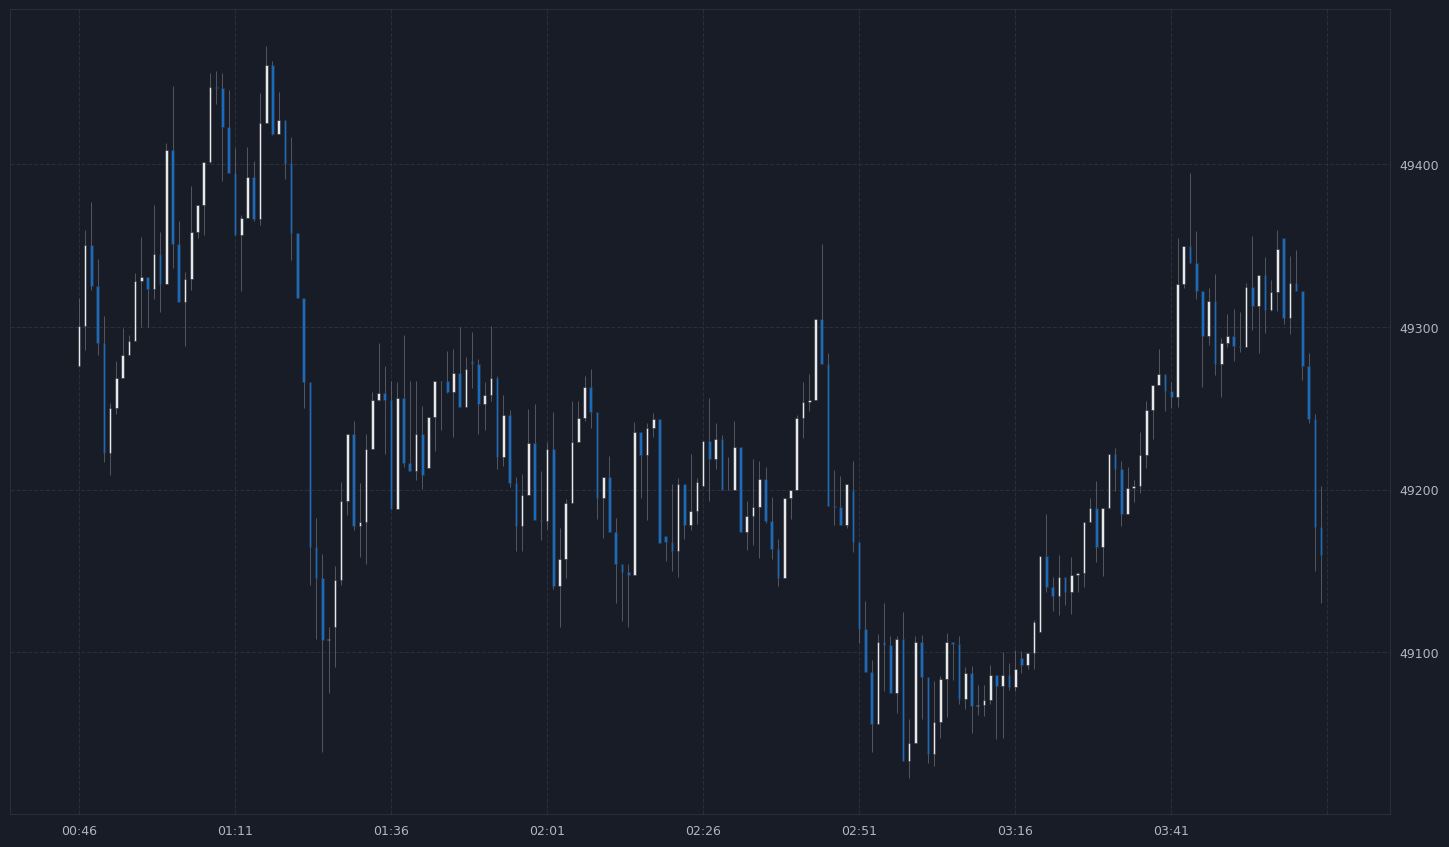

In [ ]:
get_price_plot(btc_data[-200:])

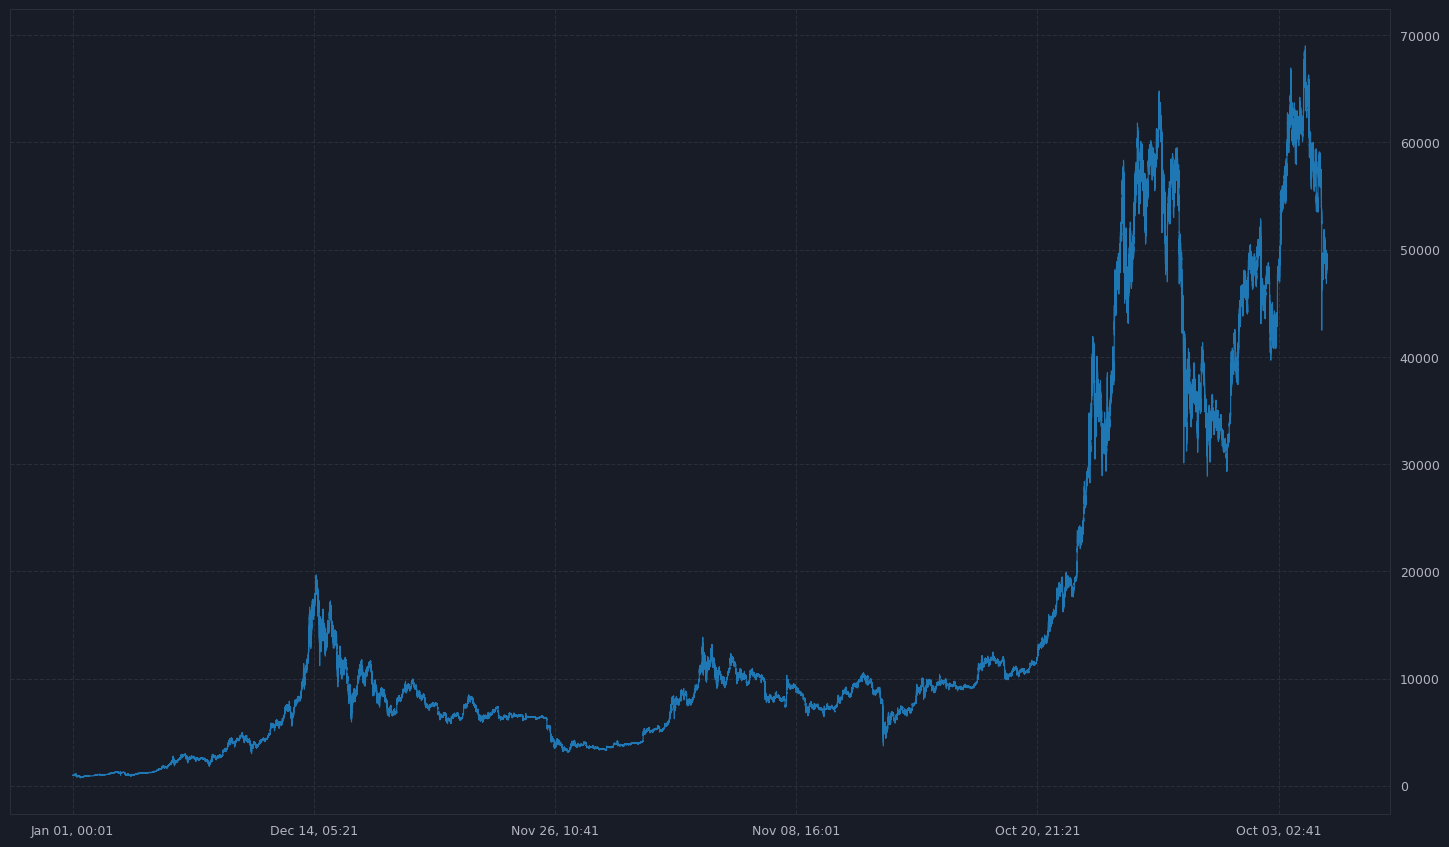

In [ ]:
get_price_plot(btc_data.iloc[:, :4], "line")

In [ ]:
btc_data.resample("W").close.mean()

date
2017-01-01      977.276060
2017-01-08      981.505302
2017-01-15      839.559408
2017-01-22      888.388665
2017-01-29      911.422007
                  ...     
2021-11-14    65382.538016
2021-11-21    59951.323800
2021-11-28    56295.731088
2021-12-05    54673.600251
2021-12-12    49289.584546
Freq: W-SUN, Name: close, Length: 259, dtype: float64

In [ ]:
btc_data.describe()

,open,high,low,close,volume_btc
count,2.600885e+06,2.600885e+06,2.600885e+06,2.600885e+06,2.600885e+06
mean,1.508671e+04,1.509753e+04,1.507557e+04,1.508665e+04,9.681493e+01
std,1.670447e+04,1.671681e+04,1.669217e+04,1.670451e+04,2.333083e+02
min,7.520000e+02,7.528100e+02,7.513400e+02,7.520400e+02,0.000000e+00
25%,5.377780e+03,5.382710e+03,5.371770e+03,5.377620e+03,1.156207e+01
50%,8.525130e+03,8.531400e+03,8.519460e+03,8.525000e+03,3.490265e+01
75%,1.307402e+04,1.308500e+04,1.306266e+04,1.307423e+04,9.366354e+01
max,6.900000e+04,6.900000e+04,6.878670e+04,6.900000e+04,2.100878e+04


In [ ]:
btc_data.corr()

,open,high,low,close,volume_btc
open,1.000000,0.999999,0.999999,0.999999,-0.094948
high,0.999999,1.000000,0.999998,0.999999,-0.094732
low,0.999999,0.999998,1.000000,0.999999,-0.095205
close,0.999999,0.999999,0.999999,1.000000,-0.094971
volume_btc,-0.094948,-0.094732,-0.095205,-0.094971,1.000000


In [ ]:
btc_data["volume_usd"] = btc_data.volume_btc * btc_data.close
columns = btc_data.columns
columns

Index(['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd'], dtype='object')

In [ ]:
for i in range(4):
  for j in range(i + 1, 4):

    btc_data[columns[i] + '-' + columns[j]] = btc_data[columns[i]] - btc_data[columns[j]]
    btc_data['|' + columns[i] + '-' + columns[j] + '|'] = abs(btc_data[columns[i]] - btc_data[columns[j]])
    btc_data[columns[i] + '*' + columns[j]] = btc_data[columns[i]] * btc_data[columns[j]]

In [ ]:
for i in columns[:4]:  
  
  btc_data["ln_" + i] = np.log(btc_data[i])
  btc_data["log10_" + i] = np.log10(btc_data[i])

In [ ]:
btc_data.shape

(2600885, 32)

In [ ]:
for i in tqdm(columns):

  btc_data["reverse_" + i] = 1 / (btc_data[i] + 0.001)
  btc_data["first_derivative_of_" + i] = np.nan
  btc_data["first_derivative_of_" + i][1:] = btc_data[i][1:].reset_index(drop=True) - btc_data[i][:-1].reset_index(drop=True)
  btc_data["second_derivative_of_" + i] = np.nan
  btc_data["second_derivative_of_" + i][2:] = btc_data[i][2:].reset_index(drop=True) - 2 * btc_data[i][1:-1].reset_index(drop=True) + btc_data[i][:-2].reset_index(drop=True)
  btc_data["per_change_" + i] = np.nan
  btc_data["per_change_" + i][1:] = (btc_data[i][1:].reset_index(drop=True) - btc_data[i][:-1].reset_index(drop=True)) / (btc_data[i][:-1].reset_index(drop=True) + 0.0001) * 100
  btc_data["per_change_" + i] = np.nan
  btc_data["per_change_" + i][1:] = (btc_data[i][1:].reset_index(drop=True) - btc_data[i][:-1].reset_index(drop=True)) / (btc_data[i][:-1].reset_index(drop=True) + 0.0001) * 100

100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


In [ ]:
btc_data.head()

,open,high,low,close,volume_btc,volume_usd,open-high,|open-high|,open*high,open-low,|open-low|,open*low,open-close,|open-close|,open*close,high-low,|high-low|,high*low,high-close,|high-close|,high*close,low-close,|low-close|,low*close,ln_open,log10_open,ln_high,log10_high,ln_low,log10_low,ln_close,log10_close,reverse_open,first_derivative_of_open,second_derivative_of_open,per_change_open,reverse_high,first_derivative_of_high,second_derivative_of_high,per_change_high,reverse_low,first_derivative_of_low,second_derivative_of_low,per_change_low,reverse_close,first_derivative_of_close,second_derivative_of_close,per_change_close,reverse_volume_btc,first_derivative_of_volume_btc,second_derivative_of_volume_btc,per_change_volume_btc,reverse_volume_usd,first_derivative_of_volume_usd,second_derivative_of_volume_usd,per_change_volume_usd
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:01:00,966.34,966.34,966.34,966.34,98.930000,95600.016200,0.00,0.00,933812.9956,0.0,0.0,933812.9956,0.00,0.00,933812.9956,0.00,0.00,933812.9956,0.0,0.0,933812.9956,0.00,0.00,933812.9956,6.873516,2.985130,6.873516,2.985130,6.873516,2.985130,6.873516,2.985130,0.001035,NaN,NaN,NaN,0.001035,NaN,NaN,NaN,0.001035,NaN,NaN,NaN,0.001035,NaN,NaN,NaN,0.010108,NaN,NaN,NaN,0.000010,NaN,NaN,NaN
2017-01-01 00:02:00,966.16,966.37,966.16,966.37,105.135892,101600.172232,-0.21,0.21,933668.0392,0.0,0.0,933465.1456,-0.21,0.21,933668.0392,0.21,0.21,933668.0392,0.0,0.0,933870.9769,-0.21,0.21,933668.0392,6.873329,2.985049,6.873547,2.985143,6.873329,2.985049,6.873547,2.985143,0.001035,-0.18,NaN,-0.018627,0.001035,0.03,NaN,0.003104,0.001035,-0.18,NaN,-0.018627,0.001035,0.03,NaN,0.003104,0.009511,6.205892,NaN,6.273007e+00,0.000010,6000.156032,NaN,6.276313e+00
2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,0.000000,0.00,0.00,933870.9769,0.0,0.0,933870.9769,0.00,0.00,933870.9769,0.00,0.00,933870.9769,0.0,0.0,933870.9769,0.00,0.00,933870.9769,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,0.001035,0.21,0.39,0.021736,0.001035,0.00,-0.03,0.000000,0.001035,0.21,0.39,0.021736,0.001035,0.00,-0.03,0.000000,1000.000000,-105.135892,-111.341785,-9.999990e+01,1000.000000,-101600.172232,-107600.328265,-1.000000e+02
2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,0.000000,0.00,0.00,933870.9769,0.0,0.0,933870.9769,0.00,0.00,933870.9769,0.00,0.00,933870.9769,0.0,0.0,933870.9769,0.00,0.00,933870.9769,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,0.001035,0.00,-0.21,0.000000,0.001035,0.00,0.00,0.000000,0.001035,0.00,-0.21,0.000000,0.001035,0.00,0.00,0.000000,1000.000000,0.000000,105.135892,0.000000e+00,1000.000000,0.000000,101600.172232,0.000000e+00
2017-01-01 00:05:00,966.43,966.43,966.43,966.43,1.391000,1344.304130,0.00,0.00,933986.9449,0.0,0.0,933986.9449,0.00,0.00,933986.9449,0.00,0.00,933986.9449,0.0,0.0,933986.9449,0.00,0.00,933986.9449,6.873609,2.985170,6.873609,2.985170,6.873609,2.985170,6.873609,2.985170,0.001035,0.06,0.06,0.006209,0.001035,0.06,0.06,0.006209,0.001035,0.06,0.06,0.006209,0.001035,0.06,0.06,0.006209,0.718391,1.391000,1.391000,1.391000e+06,0.000744,1344.304130,1344.304130,1.344304e+09


In [ ]:
np.isinf(btc_data).sum().sort_values(ascending=False)[:5]

per_change_volume_usd              0
second_derivative_of_volume_usd    0
log10_open                         0
ln_open                            0
low*close                          0
dtype: int64

In [ ]:
btc_data.isna().sum().sort_values(ascending=False)[:15]

second_derivative_of_volume_usd    2
second_derivative_of_open          2
second_derivative_of_volume_btc    2
second_derivative_of_high          2
second_derivative_of_close         2
second_derivative_of_low           2
per_change_volume_usd              1
per_change_low                     1
first_derivative_of_open           1
per_change_open                    1
per_change_high                    1
first_derivative_of_low            1
first_derivative_of_high           1
per_change_close                   1
first_derivative_of_volume_btc     1
dtype: int64

In [ ]:
btc_data.shape

(2600885, 56)

In [ ]:
btc_data.dropna(axis=0, inplace=True)
btc_data.shape, btc_data.isna().sum().max()

((2600883, 56), 0)

#PCA

In [ ]:
kmo_all, kmo_model = calculate_kmo(btc_data)
print("Global KMO = ", kmo_model)

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


Global KMO =  0.3361692872827125


In [ ]:
kmo_for_features = pd.DataFrame(data=kmo_all, index=btc_data.columns, columns=["kmo"])
kmo_for_features.sort_values(by="kmo", ascending=False).head(10)

,kmo
volume_usd,0.838295
second_derivative_of_volume_usd,0.684358
first_derivative_of_volume_usd,0.666814
open*high,0.558333
low*close,0.557826
high*close,0.557763
open*low,0.557385
per_change_volume_btc,0.518126
per_change_volume_usd,0.510706
open,0.452379


In [ ]:
kmo_for_features.sort_values(by="kmo", ascending=True).head(10)

,kmo
reverse_volume_usd,0.067682
reverse_volume_btc,0.068063
volume_btc,0.071819
second_derivative_of_open,0.077892
per_change_open,0.079732
second_derivative_of_volume_btc,0.098472
first_derivative_of_open,0.098831
second_derivative_of_high,0.105618
per_change_low,0.136072
first_derivative_of_volume_btc,0.145276


In [ ]:
columns_for_pca = kmo_for_features[kmo_for_features.kmo > 0.55].index
columns_for_pca.shape

(7,)

In [ ]:
data_for_pca = btc_data[columns_for_pca]
data_for_pca.shape

(2600883, 7)

In [ ]:
btc_data.shape[1] - columns_for_pca.size

49

In [ ]:
btc_data.drop(columns_for_pca, axis=1, inplace=True)
btc_data.shape

(2600883, 49)

In [ ]:
data_for_pca_cc = np.corrcoef(data_for_pca, rowvar=False)

In [ ]:
data_for_pca_cc.shape

(7, 7)

In [ ]:
evalsh, evecsh = np.linalg.eigh(data_for_pca_cc)
evalsh

array([3.93673597e-11, 1.45925177e-06, 1.59976228e-06, 1.32412545e-01,
       7.91463164e-01, 2.00181790e+00, 4.07430333e+00])

In [ ]:
idx = evalsh.argsort()[::-1]
evals = evalsh[idx]
evecs = evecsh[:, idx]

In [ ]:
evals

array([4.07430333e+00, 2.00181790e+00, 7.91463164e-01, 1.32412545e-01,
       1.59976228e-06, 1.45925177e-06, 3.93673597e-11])

In [ ]:
evals.sum()

7.0000000000000036

In [ ]:
data_for_pca = StandardScaler().fit_transform(data_for_pca)

In [ ]:
new_features = PCA(n_components=data_for_pca.shape[1]).fit_transform(data_for_pca)

In [ ]:
new_features

array([[-1.08823834e+00, -1.42551589e-01, -2.68865101e-01, ...,
         3.34383736e-07,  1.93880925e-04, -1.87480496e-08],
       [-1.08581341e+00, -6.75429988e-02, -3.01744102e-01, ...,
        -7.55937601e-07,  1.97999213e-04, -1.75806180e-08],
       [-1.08621648e+00, -8.61458336e-02, -2.87792975e-01, ...,
        -1.38205745e-06,  2.03410110e-04, -1.32182589e-08],
       ...,
       [ 3.81214166e+00, -4.80927078e-01, -6.13794145e-01, ...,
         1.62020509e-03, -7.19601584e-04,  4.56888800e-06],
       [ 3.95412481e+00,  8.10373707e-01, -3.05567682e-01, ...,
         3.28538680e-03,  1.52371455e-03,  7.79443556e-06],
       [ 3.91237029e+00, -4.05185878e-01,  2.62546920e-01, ...,
         8.34285545e-04,  2.25888146e-04,  2.25042719e-06]])

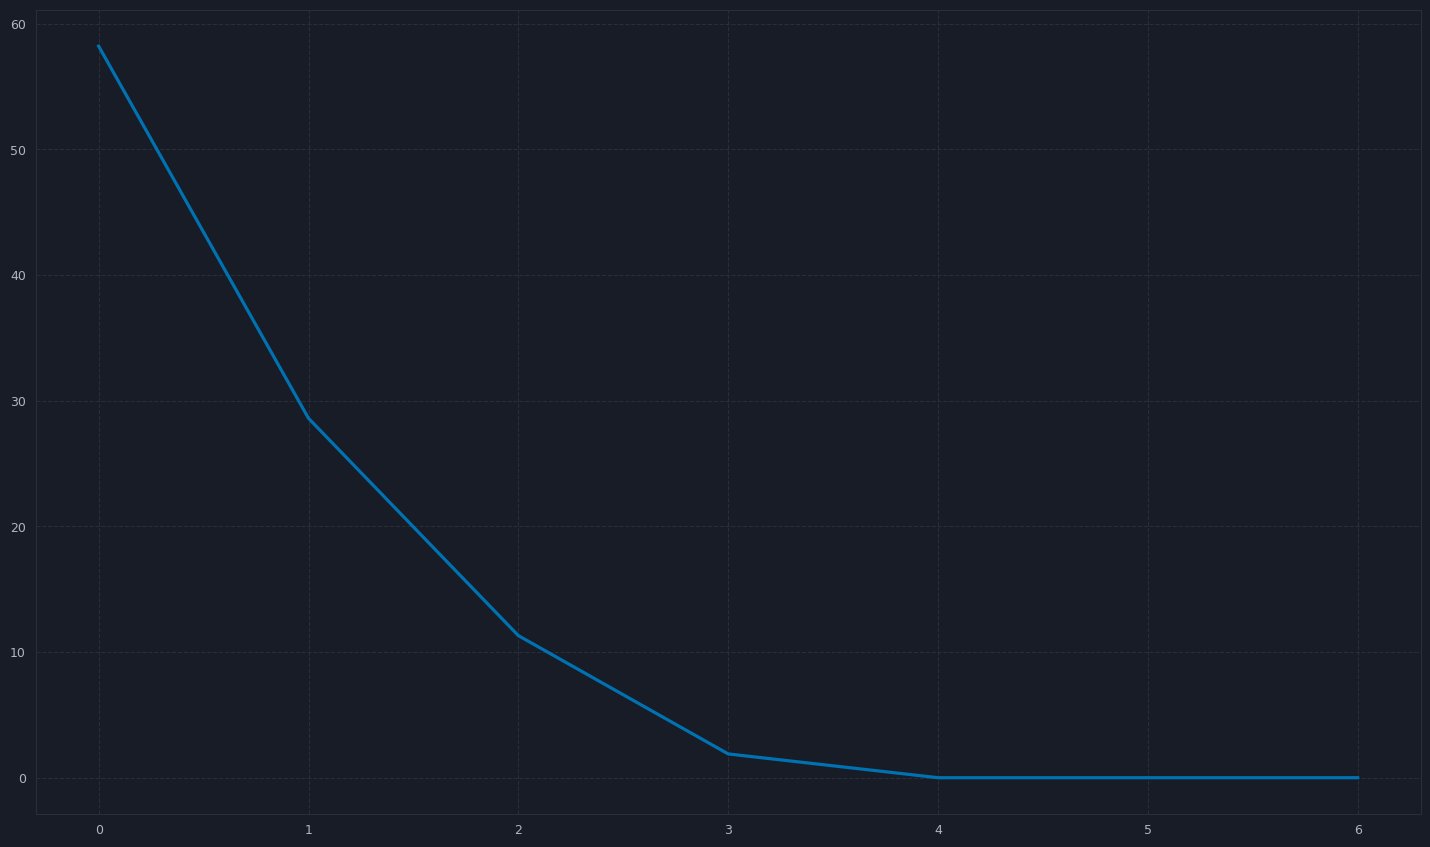

In [ ]:
set_plt_params(9)
plt.plot(evals / data_for_pca.shape[1] * 100)
plt.show()

In [ ]:
new_features = pd.DataFrame(new_features[:, :4], columns=["f_" + str(i) for i in range(1, 5)])

In [ ]:
btc_data.reset_index(inplace=True)
btc_data = pd.concat([btc_data, new_features], axis=1)
btc_data.set_index("date", inplace=True)

In [ ]:
btc_data.shape

(2600883, 53)

#Подготовка данных для модели

In [ ]:
btc_data.head()

,open,high,low,close,volume_btc,open-high,|open-high|,open-low,|open-low|,open-close,|open-close|,open*close,high-low,|high-low|,high*low,high-close,|high-close|,low-close,|low-close|,ln_open,log10_open,ln_high,log10_high,ln_low,log10_low,ln_close,log10_close,reverse_open,first_derivative_of_open,second_derivative_of_open,per_change_open,reverse_high,first_derivative_of_high,second_derivative_of_high,per_change_high,reverse_low,first_derivative_of_low,second_derivative_of_low,per_change_low,reverse_close,first_derivative_of_close,second_derivative_of_close,per_change_close,reverse_volume_btc,first_derivative_of_volume_btc,second_derivative_of_volume_btc,per_change_volume_btc,reverse_volume_usd,per_change_volume_usd,f_1,f_2,f_3,f_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:03:00,966.37,966.37,966.37,966.37,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,933870.9769,0.0,0.0,933870.9769,0.0,0.0,0.0,0.0,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,0.001035,0.21,0.39,0.021736,0.001035,0.00,-0.03,0.000000,0.001035,0.21,0.39,0.021736,0.001035,0.00,-0.03,0.000000,1000.000000,-105.135892,-111.341785,-9.999990e+01,1000.000000,-1.000000e+02,-1.088238,-0.142552,-0.268865,-0.067719
2017-01-01 00:04:00,966.37,966.37,966.37,966.37,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,933870.9769,0.0,0.0,933870.9769,0.0,0.0,0.0,0.0,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,6.873547,2.985143,0.001035,0.00,-0.21,0.000000,0.001035,0.00,0.00,0.000000,0.001035,0.00,-0.21,0.000000,0.001035,0.00,0.00,0.000000,1000.000000,0.000000,105.135892,0.000000e+00,1000.000000,0.000000e+00,-1.085813,-0.067543,-0.301744,-0.064085
2017-01-01 00:05:00,966.43,966.43,966.43,966.43,1.391000,0.0,0.0,0.0,0.0,0.0,0.0,933986.9449,0.0,0.0,933986.9449,0.0,0.0,0.0,0.0,6.873609,2.985170,6.873609,2.985170,6.873609,2.985170,6.873609,2.985170,0.001035,0.06,0.06,0.006209,0.001035,0.06,0.06,0.006209,0.001035,0.06,0.06,0.006209,0.001035,0.06,0.06,0.006209,0.718391,1.391000,1.391000,1.391000e+06,0.000744,1.344304e+09,-1.086216,-0.086146,-0.287793,-0.084097
2017-01-01 00:06:00,966.58,966.58,966.58,966.58,4.312522,0.0,0.0,0.0,0.0,0.0,0.0,934276.8964,0.0,0.0,934276.8964,0.0,0.0,0.0,0.0,6.873764,2.985238,6.873764,2.985238,6.873764,2.985238,6.873764,2.985238,0.001035,0.15,0.09,0.015521,0.001035,0.15,0.09,0.015521,0.001035,0.15,0.09,0.015521,0.001035,0.15,0.09,0.015521,0.231829,2.921522,1.530522,2.100152e+02,0.000240,2.100784e+02,-1.086003,-0.085156,-0.286790,-0.084320
2017-01-01 00:07:00,966.58,966.58,966.58,966.58,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,934276.8964,0.0,0.0,934276.8964,0.0,0.0,0.0,0.0,6.873764,2.985238,6.873764,2.985238,6.873764,2.985238,6.873764,2.985238,0.001035,0.00,-0.15,0.000000,0.001035,0.00,-0.15,0.000000,0.001035,0.00,-0.15,0.000000,0.001035,0.00,-0.15,0.000000,1000.000000,-4.312522,-7.234044,-9.999768e+01,1000.000000,-1.000000e+02,-1.086424,-0.089854,-0.286934,-0.083844


In [ ]:
btc_data.shape

(2600883, 53)

In [ ]:
x_len = 60
val_len = 396000
train_len = btc_data.shape[0] - val_len
X_train_df, X_test_df = btc_data[:train_len], btc_data[train_len + x_len + 2:]
X_train_df.shape, X_test_df.shape

((2204883, 53), (395938, 53))

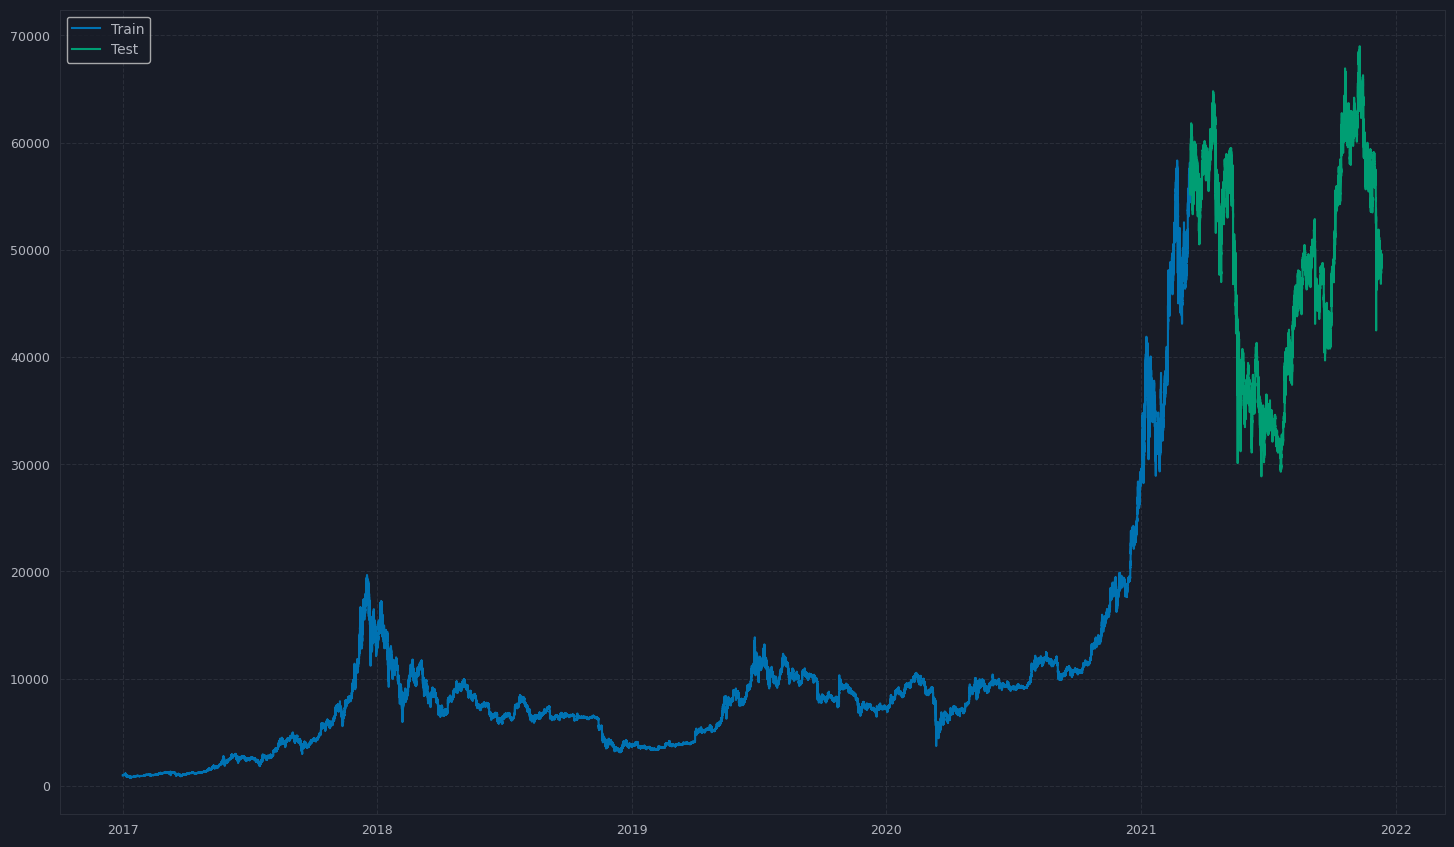

In [ ]:
set_plt_params(9, 1.5)
plt.plot(X_train_df.close, label="Train")
plt.plot(X_test_df.close, label="Test")
plt.legend()
plt.show()

In [ ]:
x_scaler = StandardScaler()
x_scaler.fit(X_train_df)
X_train = x_scaler.transform(X_train_df)
X_test = x_scaler.transform(X_test_df)

In [ ]:
y_train, y_test = btc_data["close"][:train_len].to_numpy().reshape(-1, 1), btc_data["close"][train_len + x_len + 2:].to_numpy().reshape(-1, 1)
y_scaler = StandardScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
def get_batch_size(shape):

  batches = []

  for i in range(2, 1000):
    if shape % i == 0:
      batches.append(i)
  
  if batches:
    return batches
  else:
    print("Didn't find integer divisors")

In [ ]:
print(get_batch_size(X_train.shape[0]))
print(get_batch_size(X_test.shape[0]))

[3, 9, 17, 51, 153]
[2]


In [ ]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=x_len, stride=1, batch_size=51)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=x_len, stride=1, batch_size=51)

#Создание и обучение модели

In [ ]:
def get_error_plot(history):
  
  plt.plot(history.history["loss"], 
          label="MSE train")
  plt.plot(history.history["val_loss"], 
          label="MSE validation")
  plt.legend()
  plt.show()

In [ ]:
def custom_loss_function(y_true, y_pred):

  mse = K.mean((K.square(y_true - y_pred)))
  mape = K.mean(K.abs((y_true - y_pred)/y_true))

  loss = 2 * mape + mse

  return loss

In [ ]:
def check_gpu_info(epoch, logs):

  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

In [ ]:
epochs, val_loss = 1, 1
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/models/btc_model_epoch-{epochs:02d}-val_loss-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="auto", save_freq="epoch")
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="auto", min_delta=0, cooldown=0, min_lr=0.00001)
check_gpu_on_epoch_end = LambdaCallback(on_epoch_end=check_gpu_info)

In [ ]:
def build_model(hp):

  input_data = Input(shape=(train_data_gen[0][0].shape[1], train_data_gen[0][0].shape[2]))

  for i in range(hp.Int("n_layers_cnn1", 1, 2)):

    cnn1 = Conv1D(filters=hp.Int(f"cnn1_filter_{i}", 16, 512, 16), kernel_size=hp.Int(f"cnn1_kernel_{i}", 4, 12, 2), padding="same", activation=hp.Choice(f"cnn1_activation_{i}", values=["relu", "elu", "tanh"]))(input_data)
    cnn1 = MaxPooling1D(pool_size=hp.Int(f"cnn1_max_pool_{i}", 2, 3))(cnn1)

  cnn1 = Flatten()(cnn1)

  for i in range(hp.Int("n_layers_cnn2", 1, 2)):

    cnn2 = Conv1D(filters=hp.Int(f"cnn2_filter_{i}", 16, 512, 16), kernel_size=hp.Int(f"cnn2_kernel_{i}", 4, 12, 2), padding="same", activation=hp.Choice(f"cnn2_activation_{i}", values=["relu", "elu", "tanh"]))(input_data)
    cnn2 = MaxPooling1D(pool_size=hp.Int(f"cnn2_max_pool_{i}", 2, 3))(cnn2)

  cnn2 = Flatten()(cnn2)

  merge = concatenate([cnn1, cnn2])
  dense = Dense(hp.Int(f"first_layers_dense", 128, 1024, 64), hp.Choice("dense_activation", values=["relu", "elu", "tanh"]))(merge)

  for i in range(hp.Int("n_layers_dense", 1, 3)):
    
    dense = Dense(hp.Int(f"second_layers_dense_{i}", 16, 512, 16), hp.Choice(f"dense_activation_{i}", values=["relu", "elu", "tanh"]))(dense)
    if hp.Boolean("boolean", default=True):
      dense = BatchNormalization()(dense)
      dense = Dropout(hp.Float(f"drop_out_{i}", 0.2, 0.5, 0.01))(dense)

  output = Dense(1, activation="linear")(dense)

  model = Model(input_data, output)

  model.compile(optimizer=Adam(0.0001), loss=hp.Choice("loss_func", values=["mape", "mse"]), metrics=["mape", "mae", "mse"])

  return model

In [ ]:
tuner = kt.Hyperband(build_model, objective="val_mape", max_epochs=50, directory="/content/drive/MyDrive/models")

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_data_gen, epochs=50, validation_data=test_data_gen, callbacks=[checkpoint, early_stop, reduce_lr, check_gpu_on_epoch_end])

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
model = tuner.get_best_models(1)[0]

In [ ]:
model.fit(train_data_gen, epochs=40, validation_data=test_data_gen, callbacks=[checkpoint, early_stop, reduce_lr])

#Проверка модели

In [ ]:
def get_predict(model, x_test, y_test, y_scaler):

  predict = y_scaler.inverse_transform(model.predict(x_test))
  y_test_unscaled = y_scaler.inverse_transform(y_test)
  
  return y_test_unscaled, predict

In [ ]:
def show_predict_plot(y_test_unscaled, predict, index, start=0, stop=None, x_len=x_len):

  if stop is None:
    index = index.index[x_len + start:]
  else:
    index = index.index[x_len + start: x_len + stop]

  plt.plot(index, y_test_unscaled[start:stop], 
           label="Real price")
  plt.plot(index, predict[start:stop],
           label="Predict")
  plt.legend()
  plt.show()

In [ ]:
def show_ccf_plot(y_test_unscaled, predict, lags=40):

  plt.plot(ccf(y_test_unscaled.ravel()[:lags], y_test_unscaled.ravel()[:lags]), label="y_true_acf")
  plt.plot(ccf(predict.ravel()[:lags], y_test_unscaled.ravel()[:lags]), label="predict_y_true_ccf")
  plt.plot(ccf(predict.ravel()[:lags],predict.ravel()[:lags]), label="predict_acf")
  plt.legend()
  plt.show()

In [ ]:
X_test_data = X_test[-5000:]
y_test_data = y_test[-5000:]

data_gen = TimeseriesGenerator(X_test_data, y_test_data, length=x_len, batch_size=(len(y_test_data)))
x_test_model = []
y_test_model = []

for i in tqdm(data_gen):
  x_test_model.append(i[0])
  y_test_model.append(i[1])

x_test_model = np.array(x_test_model[0])
y_test_model = np.array(y_test_model[0])

x_test_model.shape, y_test_model.shape

100%|██████████| 1/1 [00:00<00:00, 24.64it/s]


((4940, 60, 53), (4940, 1))

In [ ]:
y_test_unscaled , predict = get_predict(model, x_test_model, y_test_model, y_scaler)
y_test_unscaled.shape, predict.shape

((4940, 1), (4940, 1))

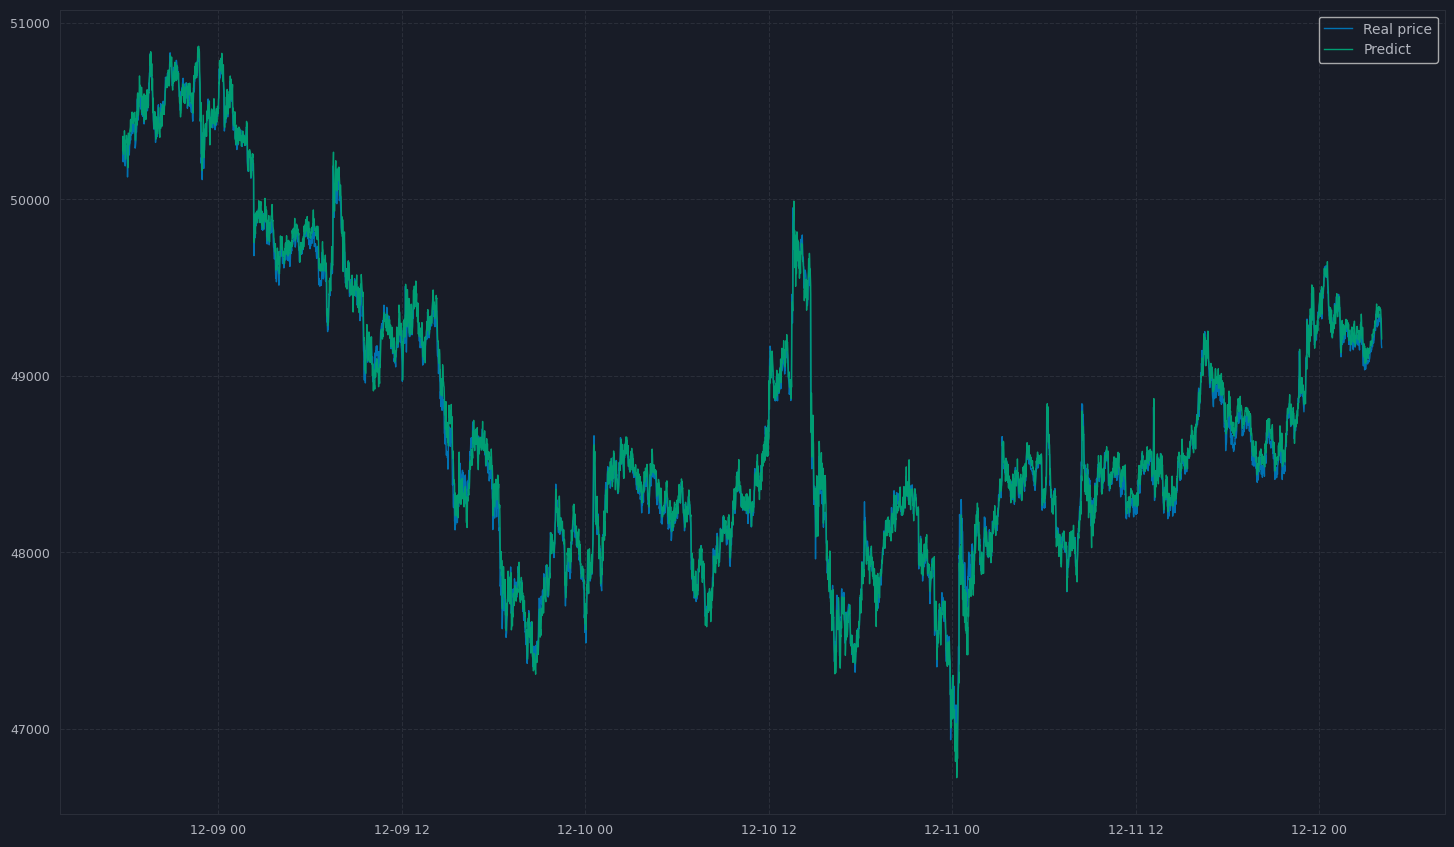

In [ ]:
set_plt_params(9, 1)
show_predict_plot(y_test_unscaled, predict, X_test_df[-5000:])

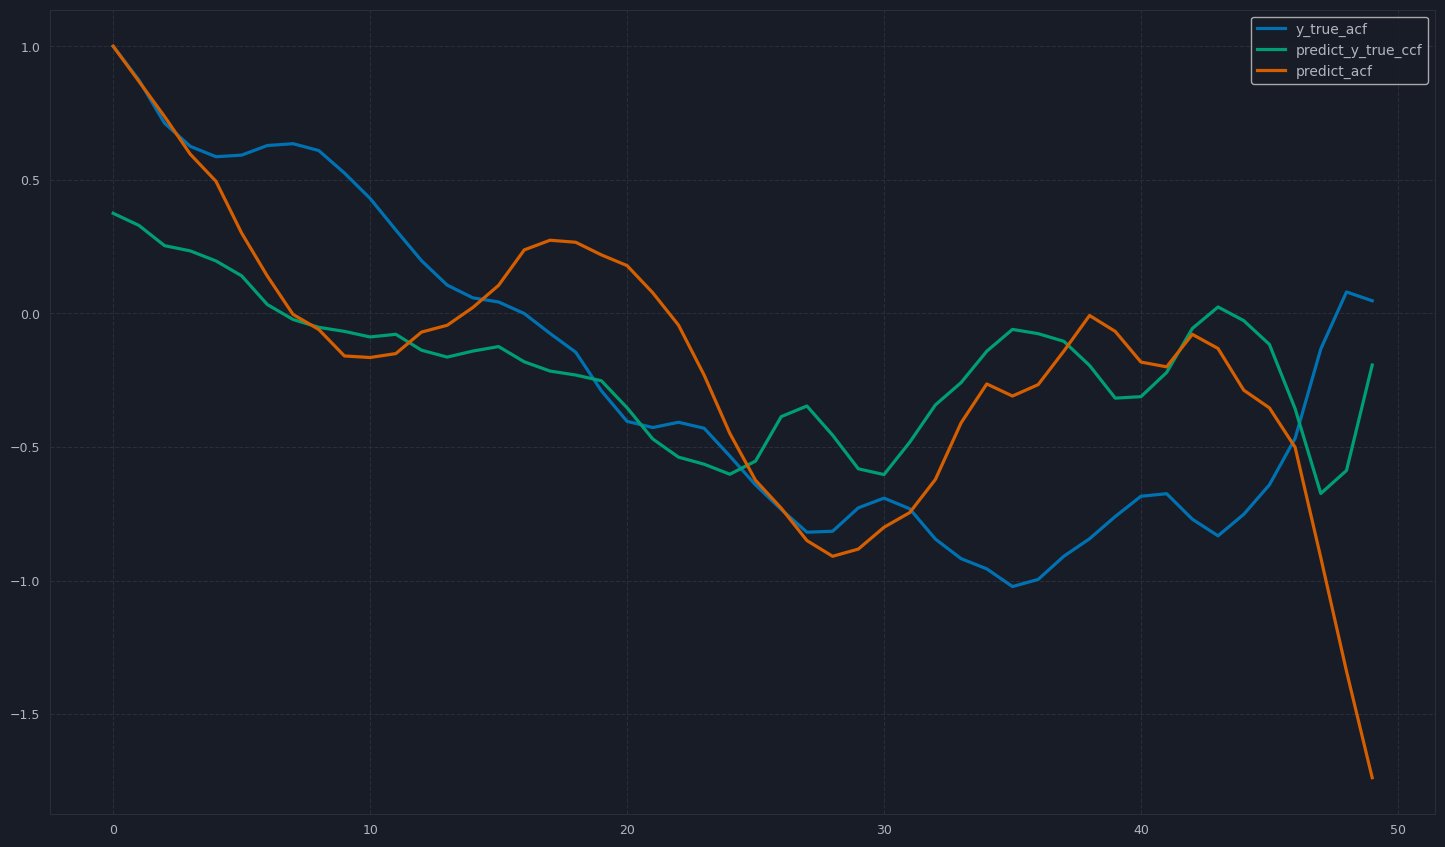

In [ ]:
show_ccf_plot(y_test_unscaled, predict, 50)